# Exercise 8-1：Titanic 是否生还-分类问题
:label:`sec_kaggle_house`  
数据集地址：https://www.kaggle.com/competitions/titanic

之前几节我们学习了一些训练深度网络的基本工具和网络正则化的技术（如权重衰减、暂退法等）。
本节我们将通过Kaggle比赛，将所学知识付诸实践。
Kaggle的房价预测比赛是一个很好的起点。
此数据集由Bart de Cock于2011年收集 :cite:`De-Cock.2011`，
涵盖了2006-2010年期间亚利桑那州埃姆斯市的房价。
这个数据集是相当通用的，不会需要使用复杂模型架构。
它比哈里森和鲁宾菲尔德的[波士顿房价](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names)
数据集要大得多，也有更多的特征。

本节我们将详细介绍数据预处理、模型设计和超参数选择。
通过亲身实践，你将获得一手经验，这些经验将指导你数据科学家职业生涯。

## 下载和缓存数据集

在整本书中，我们将下载不同的数据集，并训练和测试模型。
这里我们(**实现几个函数来方便下载数据**)。
首先，我们建立字典`DATA_HUB`，
它可以将数据集名称的字符串映射到数据集相关的二元组上，
这个二元组包含数据集的url和验证文件完整性的sha-1密钥。
所有类似的数据集都托管在地址为`DATA_URL`的站点上。
 具体内容并未实现，具体参考  
kaggle-house-price： http://localhost:8888/notebooks/chapter_multilayer-perceptrons/kaggle-house-price.ipynb



## 访问和读取数据集

注意，竞赛数据分为训练集和测试集。
每条记录都包括房屋的属性值和属性，如街道类型、施工年份、屋顶类型、地下室状况等。
这些特征由各种数据类型组成。
例如，建筑年份由整数表示，屋顶类型由离散类别表示，其他特征由浮点数表示。
这就是现实让事情变得复杂的地方：例如，一些数据完全丢失了，缺失值被简单地标记为“NA”。
每套房子的价格只出现在训练集中（毕竟这是一场比赛）。
我们将希望划分训练集以创建验证集，但是在将预测结果上传到Kaggle之后，
我们只能在官方测试集中评估我们的模型。
在 :numref:`fig_house_pricing` 中，"Data"选项卡有下载数据的链接。

开始之前，我们将[**使用`pandas`读入并处理数据**]，
这是我们在 :numref:`sec_pandas`中引入的。
因此，在继续操作之前，你需要确保已安装`pandas`。
幸运的是，如果你正在用Jupyter阅读该书，你可以在不离开笔记本的情况下安装`pandas`。


In [61]:
# 如果你没有安装pandas，请取消下一行的注释
# !pip install pandas

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

我们使用`pandas`分别加载包含训练数据和测试数据的两个CSV文件。


In [62]:
# download('kaggle_house_train')
# train_data = pd.read_csv(download('kaggle_house_train'))
# test_data = pd.read_csv(download('kaggle_house_test'))
train_data_fname = './titanic\\train.csv'
test_data_fname = './titanic\\test.csv'
train_data = pd.read_csv(train_data_fname)
test_data = pd.read_csv(test_data_fname)

训练数据集包括xx个样本，每个样本xx个特征和1个标签，
而测试数据集包含xx个样本，每个样本xx个特征。


In [63]:
print(train_data.shape)
print(test_data.shape)
print(type(train_data))
print(train_data.columns)

(891, 12)
(418, 11)
<class 'pandas.core.frame.DataFrame'>
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


让我们看看[**前四个和最后两个特征，以及相应标签**]。


In [64]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   

                                                Name     Fare Cabin Embarked  
0                            Braund, Mr. Owen Harris   7.2500   NaN        S  
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  71.2833   C85        C  
2                             Heikkinen, Miss. Laina   7.9250   NaN        S  
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  53.1000  C123        S  


我们可以看到，(**在每个样本中，第一个特征是ID，**)
这有助于模型识别每个训练样本。
虽然这很方便，但它不携带任何用于预测的信息。
因此，在将数据提供给模型之前，(**我们将其从数据集中删除**)。


In [65]:
 # 将train_data 和test_data合并一起处理
# 注意这里删除了第一个特征ID，因为它不携带任何预测信息
#因为预测值为第二个特征，故除去
all_features = pd.concat((train_data.iloc[:, 2:-1], test_data.iloc[:, 1:]))
all_features

Pclass                                               Name     Sex   Age  \
0         3                            Braund, Mr. Owen Harris    male  22.0   
1         1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
2         3                             Heikkinen, Miss. Laina  female  26.0   
3         1       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
4         3                           Allen, Mr. William Henry    male  35.0   
..      ...                                                ...     ...   ...   
413       3                                 Spector, Mr. Woolf    male   NaN   
414       1                       Oliva y Ocana, Dona. Fermina  female  39.0   
415       3                       Saether, Mr. Simon Sivertsen    male  38.5   
416       3                                Ware, Mr. Frederick    male   NaN   
417       3                           Peter, Master. Michael J    male   NaN   

     SibSp  Parch              Ticket      Fare Cabin Embarked  
0        1      0           A/5 21171    7.2500   NaN      NaN  
1        1      0            PC 17599   71.2833   C85      NaN  
2        0      0    STON/O2. 3101282    7.9250   NaN      NaN  
3        1      0              113803   53.1000  C123      NaN  
4        0      0              373450    8.0500   NaN      NaN  
..     ...    ...                 ...       ...   ...      ...  
413      0      0           A.5. 3236    8.0500   NaN        S  
414      0      0            PC 17758  108.9000  C105        C  
415      0      0  SOTON/O.Q. 3101262    7.2500   NaN        S  
416      0      0              359309    8.0500   NaN        S  
417      1      1                2668   22.3583   NaN        C  

[1309 rows x 10 columns]

## 数据预处理

如上所述，我们有各种各样的数据类型。
在开始建模之前，我们需要对数据进行预处理。
首先，我们[**将所有缺失的值替换为相应特征的平均值。**]然后，为了将所有特征放在一个共同的尺度上，
我们(**通过将特征重新缩放到零均值和单位方差来标准化数据**)：

$$x \leftarrow \frac{x - \mu}{\sigma},$$

其中 **$\mu$和$\sigma$分别表示均值和标准差** 。
现在，这些特征具有零均值和单位方差，即 $E[\frac{x-\mu}{\sigma}] = \frac{\mu - \mu}{\sigma} = 0$和$E[(x-\mu)^2] = (\sigma^2 + \mu^2) - 2\mu^2+\mu^2 = \sigma^2$。
直观地说，我们标准化数据有两个原因：
首先，它方便优化。
其次，因为我们不知道哪些特征是相关的，
所以我们不想让惩罚分配给一个特征的系数比分配给其他任何特征的系数更大。


In [66]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
# 这个地方其实是要注意的，因为normalization应该统一用train set的均值和方差
# 这里其实是小小的作弊了哈哈 因为测试集的均值和方差在这里被观察到了，不再是一个严格意义上的blind data了
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)
all_features.shape


(1309, 10)

### 处理离散值数据
#### 独热编码
接下来，我们[**处理离散值。**]
这包括诸如“MSZoning”之类的特征。
(**我们用独热编码替换它们**)，
方法与前面将多类别标签转换为向量的方式相同
（请参见 :numref:`subsec_classification-problem`）。
例如，“MSZoning”包含值“RL”和“Rm”。
我们将创建两个新的指示器特征“MSZoning_RL”和“MSZoning_RM”，其值为0或1。
根据独热编码，如果“MSZoning”的原始值为“RL”，
则：“MSZoning_RL”为1，“MSZoning_RM”为0。
`pandas`软件包会自动为我们实现这一点。  
**因为能直接对整个数据集进行独热编码，故先对特殊的特征进行embedding编码，然后对其余行进行独热编码。**

In [67]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
# all_features = pd.get_dummies(all_features, dummy_na=True)
# all_features.shape
# all_features

#### embedding编码
对于有许多不同的值的特征，使用独热编码，会占用过多的存储空间。比如：Name有418 unique values  
**因为能直接对整个数据集进行独热编码，故先对特殊的特征进行embedding编码，然后对其余行进行独热编码。**

In [68]:

# 因为Address特征一列有很多值，故将字符串直接映射为int值
embed_column_names = ["Name","Cabin","Ticket"]
# one_hot_column_names = ["Sex",]
for embed_column_name in embed_column_names:
    all_features[embed_column_name] = pd.factorize(all_features[embed_column_name])[0].astype(int)
all_features

Pclass  Name     Sex       Age     SibSp     Parch  Ticket      Fare  \
0    0.841595     0    male -0.546789  0.481104 -0.444829       0 -0.503210   
1   -1.545507     1  female  0.563282  0.481104 -0.444829       1  0.733941   
2    0.841595     2  female -0.269271 -0.478904 -0.444829       2 -0.490169   
3   -1.545507     3  female  0.355144  0.481104 -0.444829       3  0.382632   
4    0.841595     4    male  0.355144 -0.478904 -0.444829       4 -0.487754   
..        ...   ...     ...       ...       ...       ...     ...       ...   
413  0.841595  1302    male  0.000000 -0.478904 -0.444829     926 -0.487754   
414 -1.545507  1303  female  0.632662 -0.478904 -0.444829     273  1.460712   
415  0.841595  1304    male  0.597972 -0.478904 -0.444829     927 -0.503210   
416  0.841595  1305    male  0.000000 -0.478904 -0.444829     928 -0.487754   
417  0.841595  1306    male  0.000000  0.481104  0.710492     119 -0.211311   

     Cabin Embarked  
0       -1      NaN  
1        0      NaN  
2       -1      NaN  
3        1      NaN  
4       -1      NaN  
..     ...      ...  
413     -1        S  
414    185        C  
415     -1        S  
416     -1        S  
417     -1        C  

[1309 rows x 10 columns]

In [69]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape
all_features

Pclass  Name       Age     SibSp     Parch  Ticket      Fare  Cabin  \
0    0.841595     0 -0.546789  0.481104 -0.444829       0 -0.503210     -1   
1   -1.545507     1  0.563282  0.481104 -0.444829       1  0.733941      0   
2    0.841595     2 -0.269271 -0.478904 -0.444829       2 -0.490169     -1   
3   -1.545507     3  0.355144  0.481104 -0.444829       3  0.382632      1   
4    0.841595     4  0.355144 -0.478904 -0.444829       4 -0.487754     -1   
..        ...   ...       ...       ...       ...     ...       ...    ...   
413  0.841595  1302  0.000000 -0.478904 -0.444829     926 -0.487754     -1   
414 -1.545507  1303  0.632662 -0.478904 -0.444829     273  1.460712    185   
415  0.841595  1304  0.597972 -0.478904 -0.444829     927 -0.503210     -1   
416  0.841595  1305  0.000000 -0.478904 -0.444829     928 -0.487754     -1   
417  0.841595  1306  0.000000  0.481104  0.710492     119 -0.211311     -1   

     Sex_female  Sex_male  Sex_nan  Embarked_C  Embarked_Q  Embarked_S  \
0             0         1        0           0           0           0   
1             1         0        0           0           0           0   
2             1         0        0           0           0           0   
3             1         0        0           0           0           0   
4             0         1        0           0           0           0   
..          ...       ...      ...         ...         ...         ...   
413           0         1        0           0           0           1   
414           1         0        0           1           0           0   
415           0         1        0           0           0           1   
416           0         1        0           0           0           1   
417           0         1        0           1           0           0   

     Embarked_nan  
0               1  
1               1  
2               1  
3               1  
4               1  
..            ...  
413             0  
414             0  
415             0  
416             0  
417             0  

[1309 rows x 15 columns]

你可以看到，此转换会将特征的总数量从79个增加到331个。
最后，通过`values`属性，我们可以
[**从`pandas`格式中提取NumPy格式，并将其转换为张量表示**]用于训练。


In [70]:
# 前面将训练集和测试集加在了一起，这里是再将这两个分开
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
# Survived 是 train.csv数据集中预测结果label标签，即y^hat
train_labels = torch.tensor(
    train_data["Survived"].values.reshape(-1, 1), dtype=torch.float32)
n_train,train_features.shape,test_features.shape

(891, torch.Size([891, 15]), torch.Size([418, 15]))

## 形成训练测试数据集

自己写：参考之前学的
"""
## ① Prepare dataset
 Dataset and Dataloader
"""

In [73]:
from torch.utils.data import Dataset, DataLoader

class TitanicDataset(Dataset):
    
    def __init__(self,isTrain,ratio):
        total_len =  train_features.shape[0]  # shape(多少行，多少列)
        self.len = int( total_len * ratio / 100)
        
#         print(type(train_features))
        if isTrain:
            self.x_data = train_features[:self.len]
            self.y_data = train_labels[:self.len]
        else:
            self.x_data = train_features[self.len:]
            self.y_data = train_labels[self.len:] 

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len
train_dataset = TitanicDataset(isTrain=True,ratio=8)    
validation_dataset = TitanicDataset(isTrain=False,ratio=8)    
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=0)  # num_workers 多线程
validation_loader = DataLoader(dataset=validation_dataset, batch_size=32, shuffle=True)  # num_workers 多线程

"""
## ②Design model using Class
inherit from nn.Module
"""

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear1 = torch.nn.Linear(15, 10)
        self.linear2 = torch.nn.Linear(10, 6)
        self.linear3 = torch.nn.Linear(6, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.linear1(x))
        x = self.sigmoid(self.linear2(x))
        x = self.sigmoid(self.linear3(x))
        return x


model = Model()
print(train_features.shape)

AssertionError: 0.0

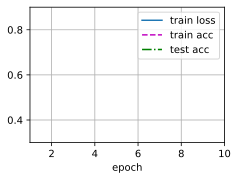

In [74]:

'''
③Construct loss and optimizer
using PyTorch API
'''
criterion = torch.nn.BCELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
d2l.train_ch3(model, train_loader, validation_loader, criterion, 10, optimizer)
'''
④Training cycle
forward, backward, update
'''
# # if __name__ == '__main__':
# for epoch in range(100):
#     for i, data in enumerate(train_loader, 0):  # train_loader 是先shuffle后mini_batch
#         # 1. Prepare data
#         inputs, labels = data
# #             print(type(inputs))
#         # 2. Forward
#         y_pred = model(inputs)
#         loss = criterion(y_pred, labels)
#         print(epoch, i, loss.item())
#         # 3. Backward
#         optimizer.zero_grad()
#         loss.backward()
#         # 4. Update
#         optimizer.step()


# other

## [**训练**]

首先，我们训练一个带有损失平方的线性模型。
显然线性模型很难让我们在竞赛中获胜，但线性模型提供了一种健全性检查，
以查看数据中是否存在有意义的信息。
如果我们在这里不能做得比随机猜测更好，那么我们很可能存在数据处理错误。
如果一切顺利，线性模型将作为*基线*（baseline）模型，
让我们直观地知道最好的模型有超出简单的模型多少。


In [18]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(15, 10),
                    nn.ReLU(),
                    nn.Linear(10, 6),
                    nn.Linear(6, 4),
                    nn.ReLU(),
                    nn.Linear(4, 2))
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

### 训练
可以借鉴
image-classification-dataset：
http://localhost:8889/notebooks/chapter_linear-networks/image-classification-dataset.ipynb

In [ ]:
# def load_data_fashion_mnist(batch_size, resize=None):  #@save
#     """下载Fashion-MNIST数据集，然后将其加载到内存中"""
#     trans = [transforms.ToTensor()]
#     if resize:
#         trans.insert(0, transforms.Resize(resize))
#     trans = transforms.Compose(trans)
#     mnist_train = torchvision.datasets.FashionMNIST(
#         root="../data", train=True, transform=trans, download=True)
#     mnist_test = torchvision.datasets.FashionMNIST(
#         root="../data", train=False, transform=trans, download=True)
#     return (data.DataLoader(mnist_train, batch_size, shuffle=True,
#                             num_workers=get_dataloader_workers()),
#             data.DataLoader(mnist_test, batch_size, shuffle=False,
#                             num_workers=get_dataloader_workers()))

In [14]:
# batch_size, lr, num_epochs = 256, 0.1, 10
# loss = nn.CrossEntropyLoss(reduction='none')
# trainer = torch.optim.SGD(net.parameters(), lr=lr)

In [22]:
# from d2l import torch as d2l
# train_iter, test_iter = train_features,test_features
# d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [23]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

房价就像股票价格一样，我们关心的是相对数量，而不是绝对数量。
因此，[**我们更关心相对误差$\frac{y - \hat{y}}{y}$，**]
而不是绝对误差$y - \hat{y}$。
例如，如果我们在俄亥俄州农村地区估计一栋房子的价格时，
假设我们的预测偏差了10万美元，
然而那里一栋典型的房子的价值是12.5万美元，
那么模型可能做得很糟糕。
另一方面，如果我们在加州豪宅区的预测出现同样的10万美元的偏差，
（在那里，房价中位数超过400万美元）
这可能是一个不错的预测。

(**解决这个问题的一种方法是用价格预测的对数来衡量差异**)。
事实上，这也是比赛中官方用来评价提交质量的误差指标。
即将$\delta$ for $|\log y - \log \hat{y}| \leq \delta$
转换为$e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$。
这使得预测价格的对数与真实标签价格的对数之间出现以下均方根误差：

$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$$


In [24]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
#     log a - log b = log a/b
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

与前面的部分不同，[**我们的训练函数将借助Adam优化器**]
（我们将在后面章节更详细地描述它）。
Adam优化器的主要吸引力在于它对初始学习率不那么敏感。


In [25]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## $K$折交叉验证

你可能还记得，我们在讨论模型选择的部分（ :numref:`sec_model_selection`）
中介绍了[**K折交叉验证**]，
它有助于模型选择和超参数调整。
我们首先需要定义一个函数，在$K$折交叉验证过程中返回第$i$折的数据。
具体地说，它选择第$i$个切片作为验证数据，其余部分作为训练数据。
注意，这并不是处理数据的最有效方法，如果我们的数据集大得多，会有其他解决办法。


In [26]:
def get_k_fold_data(k, i, X, y):
#     Python assert（断言）用于判断一个表达式，在表达式条件为 false 的时候触发异常
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
#         slice()和切片区别在于 slice只用传一个对象进[].切片要显示指定[x:y
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

当我们在$K$折交叉验证中训练$K$次后，[**返回训练和验证误差的平均值**]。


In [27]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

## [**模型选择**]

在本例中，我们选择了一组未调优的超参数，并将其留给读者来改进模型。
找到一组调优的超参数可能需要时间，这取决于一个人优化了多少变量。
有了足够大的数据集和合理设置的超参数，$K$折交叉验证往往对多次测试具有相当的稳定性。
然而，如果我们尝试了不合理的超参数，我们可能会发现验证效果不再代表真正的误差。


折1，训练log rmseinf, 验证log rmseinf
折2，训练log rmseinf, 验证log rmseinf
折3，训练log rmseinf, 验证log rmseinf
折4，训练log rmseinf, 验证log rmseinf
折5，训练log rmseinf, 验证log rmseinf
5-折验证: 平均训练log rmse: inf, 平均验证log rmse: inf


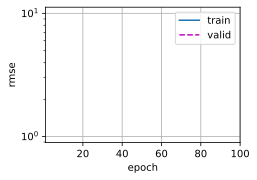

In [28]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

请注意，有时一组超参数的训练误差可能非常低，但$K$折交叉验证的误差要高得多，
这表明模型过拟合了。
在整个训练过程中，你将希望监控训练误差和验证误差这两个数字。
较少的过拟合可能表明现有数据可以支撑一个更强大的模型，
较大的过拟合可能意味着我们可以通过正则化技术来获益。

##  [**提交你的Kaggle预测**]

既然我们知道应该选择什么样的超参数，
我们不妨使用所有数据对其进行训练
（而不是仅使用交叉验证中使用的$1-1/K$的数据）。
然后，我们通过这种方式获得的模型可以应用于测试集。
将预测保存在CSV文件中可以简化将结果上传到Kaggle的过程。


In [46]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['Sold Price'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

如果测试集上的预测与$K$倍交叉验证过程中的预测相似，
那就是时候把它们上传到Kaggle了。
下面的代码将生成一个名为`submission.csv`的文件。


In [54]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

AssertionError: Size mismatch between tensors

接下来，如 :numref:`fig_kaggle_submit2`中所示，
我们可以提交预测到Kaggle上，并查看在测试集上的预测与实际房价（标签）的比较情况。
步骤非常简单：

* 登录Kaggle网站，访问房价预测竞赛页面。
* 点击“Submit Predictions”或“Late Submission”按钮（在撰写本文时，该按钮位于右侧）。
* 点击页面底部虚线框中的“Upload Submission File”按钮，选择你要上传的预测文件。
* 点击页面底部的“Make Submission”按钮，即可查看你的结果。

![向Kaggle提交数据](../img/kaggle-submit2.png)
:width:`400px`
:label:`fig_kaggle_submit2`

## 小结

* 真实数据通常混合了不同的数据类型，需要进行预处理。
* 常用的预处理方法：将实值数据重新缩放为零均值和单位方法；用均值替换缺失值。
* 将类别特征转化为指标特征，可以使我们把这个特征当作一个独热向量来对待。
* 我们可以使用$K$折交叉验证来选择模型并调整超参数。
* 对数对于相对误差很有用。

## 练习

1. 把你的预测提交给Kaggle，它有多好？
1. 你能通过直接最小化价格的对数来改进你的模型吗？如果你试图预测价格的对数而不是价格，会发生什么？
1. 用平均值替换缺失值总是好主意吗？提示：你能构造一个不随机丢失值的情况吗？
1. 通过$K$折交叉验证调整超参数，从而提高Kaggle的得分。
1. 通过改进模型（例如，层、权重衰减和dropout）来提高分数。
1. 如果我们没有像本节所做的那样标准化连续的数值特征，会发生什么？


[Discussions](https://discuss.d2l.ai/t/1824)
